# **Emplear regularización estadística para el diseño de geometrías de adquisición sísmica**

Este notebook contiene detallademente el código realizado para realizar las simulaciones del artículo "Divergence-Based Regularization for End-to-End Sensing Matrix Optimization in Compressive Sampling Systems" 

[Enlace del artículo](https://www.researchgate.net/profile/Constantin-Paleologu/publication/369369746_The_Eighth_International_Conference_on_Advances_in_Signal_Image_and_Video_Processing_SIGNAL_2023_ISBN_978-1-68558-057-5_March_13th_-_17th_2023_Barcelona_Spain/links/6417ed2e92cfd54f84144d21/The-Eighth-International-Conference-on-Advances-in-Signal-Image-and-Video-Processing-SIGNAL-2023-ISBN-978-1-68558-057-5-March-13th-17th-2023-Barcelona-Spain.pdf#page=80)


Sincronizar Drive e instalar paquetes necesarios

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%cd /content/drive/My Drive/hdsp/Seismic_Design
# !pip install sporco

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/hdsp/Seismic_Design


Cargar librerias

In [2]:
import os
import tensorflow as tf


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=24 * 1024)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

from tensorflow.keras.layers import *
from Unet2D import *
from Conv import *
from SensingModel2D import *
from metrics import *
from models2D import *
from sampling_schemes import *
from plots import *
from utils import *


1 Physical GPUs, 1 Logical GPUs


Cargar y procesar STEAM PHASE II Dataset
* El dataset de carga como arreglo de numpy
* Se reorganiza la base de datos para que quede de dimensiones S,M,N donde S son los números de shots, M, el números de muestra en tiempo y N el número de receptores.
* Se realiza la divsión de la base de datos en conjunto de entrenamiento, validación y pureba. 
* Se normaliza los datos para que esten entre 0 y 1 

In [3]:

path = os.path.join("..", "..", "Data")
path_results = os.path.join("..", "Results_2D")
Data = np.load('Data_seismic/Data2D.npy')



Data_resh = Data[np.newaxis,:,:,:]
Data_resh = np.transpose(Data_resh, (3,1,2,0))

idx = np.random.permutation(Data.shape[2])
idx_train = idx[0:int(Data.shape[2]*0.1)]
idx_pred = idx[int(Data.shape[2]*0.1):int(Data.shape[2]*0.2)]
idx_val = idx[int(Data.shape[2]*0.9):Data.shape[2]]

DataTrain = normalize_data(Data_resh[idx_train,:,:,:])
DataPred = normalize_data(Data_resh[idx_pred,:,:,:])
DataVal = normalize_data(Data_resh[idx_val,:,:,:])

print('Data train size ' + str(DataTrain.shape))
print('Data test size ' + str(DataPred.shape))


Data train size (321, 128, 128, 1)
Data test size (321, 128, 128, 1)


Parámetros del sistema de adquisición, el modelo de reconstrucción y la selección del regularizador
* Se selección el *sampling rate* (SR)
* Se construcye el modelo de reconstrucción y modelo de adquisición
* Se escoge el tipo de regualrizador que se va a emplear para el diseño de la geometría de adquisición. Se selección entre la divergencia KL Gaussiana o Laplaciana
* Los parámetros del regularizador (media y varianza) son definidos


In [14]:
SR = 0.6

latent_dim = DataTrain.shape[1]
PROPOSED = True

recons_net = conv_model(DataTrain)
mask_model = sensing_model(latent_dim, trainable=PROPOSED)
reg = 'kl-laplacian' #kl-laplacian, kl-gaussian
mean = 1.0
stddev = 1.0

Construir y entrenar el modelo 

* Se construcye el modelo completo de extremo a extremo
* Se ajustan los hyperparametros del entrenamiento del modelo tales como el optimizador, la tasa de aprendizaje
* Se programan *callbacks* para el guardado del modelo y de sus métricas


0.5 0.5
removed traces: tf.Tensor(102.0, shape=(), dtype=float32)
sampling rate is: tf.Tensor(79.6875, shape=(), dtype=float32)


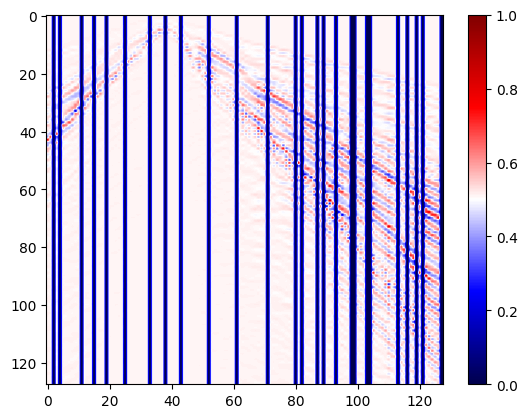

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 mask_model (Sequential)        (None, 128, 128, 1)  16512       ['input_4[0][0]']                
                                                                                                  
 model (Functional)             (None, 128, 128, 1)  445185      ['mask_model[2][0]']             
                                                                                                  
 tf.math.reduce_mean_6 (TFOpLam  (None,)             0           ['mask_model[2][0]']       

In [8]:

if os.path.exists(path_results):
  pass
else:
  os.mkdir(path_results)
model = build_model(recons_net, mask_model, DataTrain[0,:,:,:].shape,type_reg=reg,mean=mean,stddev=stddev,regularization=True,param=param)
# mask_model.save_weights(path_results + 'baseline.h5')

# if not PROPOSED:
#     mask_model.load_weights(path_results + 'baseline.h5')

# save initial PHI matrix
weights_init = binary_sigmoid_unit(mask_model.get_weights()[0]@mask_model.get_weights()[1]) # matrix product Az to get the weights
#weights_init = binary_sigmoid_unit(mask_model.get_weights()[0]) # save weights
print('removed traces: ' + str(tf.math.reduce_sum(weights_init)) +
f'\nsampling rate is: ' + str(tf.math.reduce_sum(weights_init)*100/DataTrain.shape[2]))
csv_file =path_results+'/results.csv'
csv_log = tf.keras.callbacks.CSVLogger(csv_file, separator=',', append=False)
# plot initial mask
plot_mask(mask_model(DataTrain), 2) # entries are Data and shot

# model compilation
model.compile(optimizer=tf.optimizers.Adam(0.0005), loss="mse", metrics=[get_psnr()],run_eagerly=True)
model.summary(print_fn=myprint(model.summary))
recons_net.summary()

history = model.fit(x=DataTrain,
                    y=DataTrain,
                    shuffle=True,
                    batch_size=100,
                    epochs=20,
                    validation_data=(DataPred, DataPred),
                    callbacks = [reduce_lr(), mcp_save(path_results),csv_log])

Mostrar Resultados Visuales

non-removed traces: tf.Tensor(81.0, shape=(), dtype=float32)
sampling rate is: tf.Tensor(63.28125, shape=(), dtype=float32)


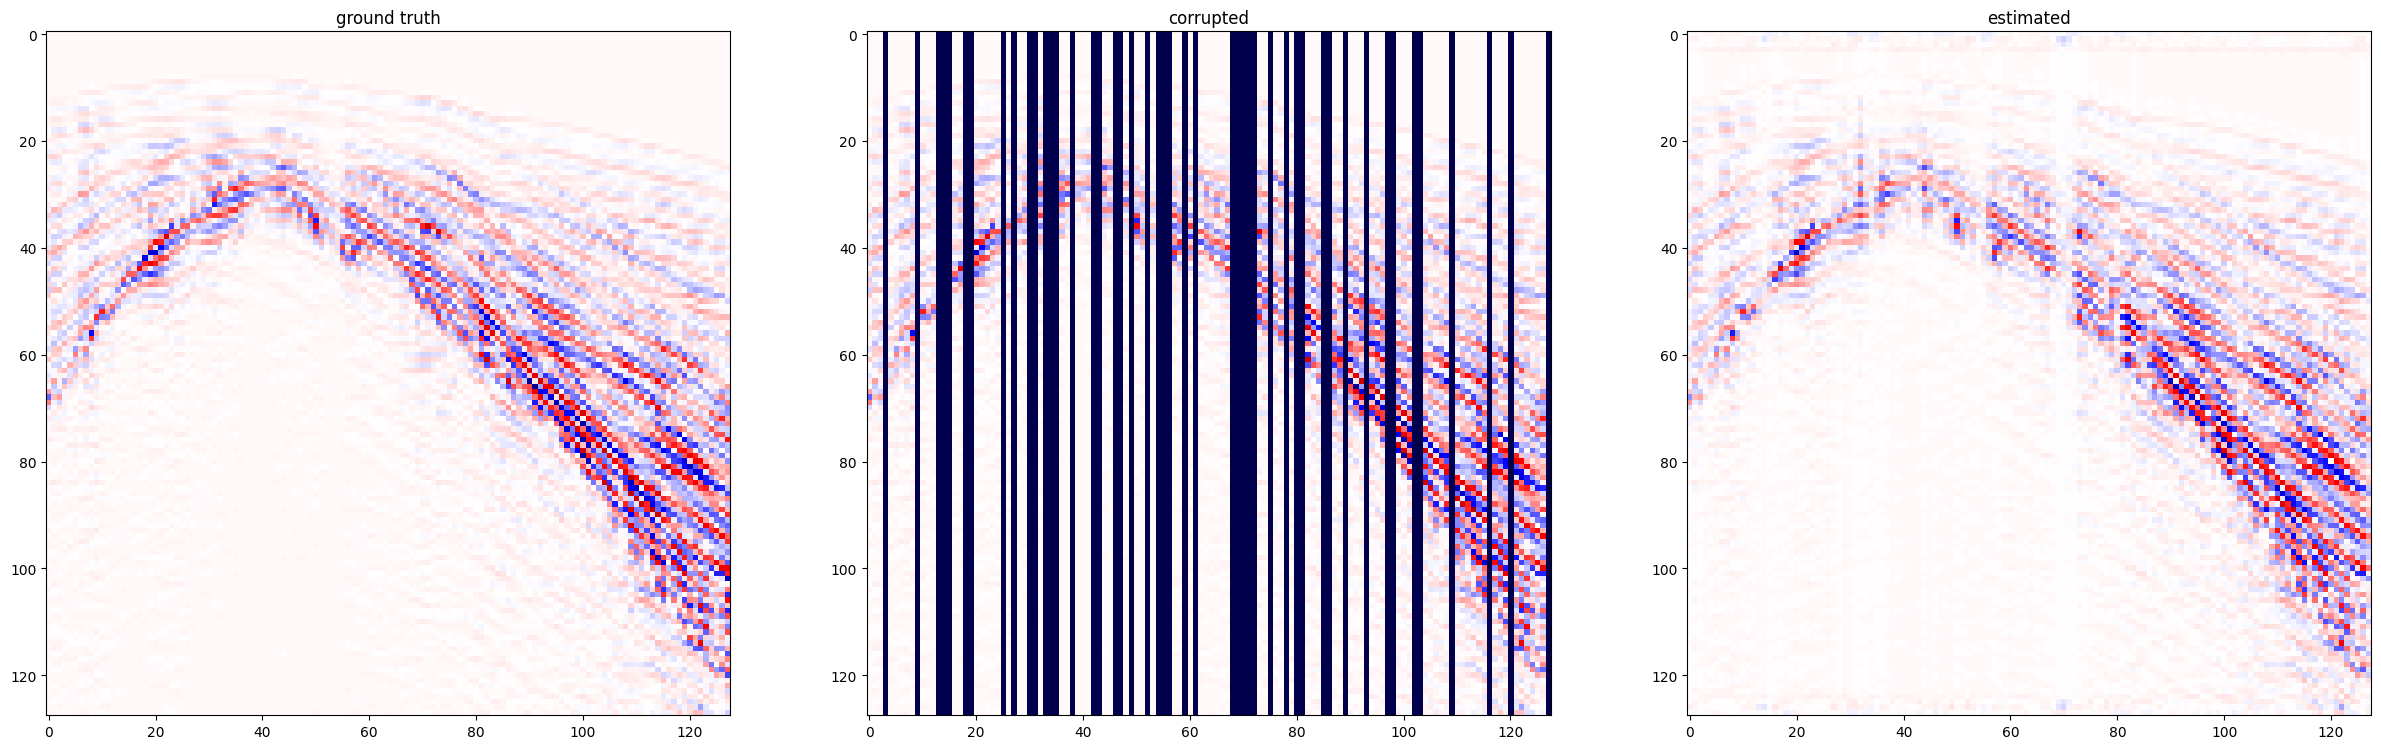

In [13]:

# plot_loss_normalized(history.history['psnr'][10:], history.history['val_psnr'][10:], w=4)

# data test
DataPred_test = DataPred[0:50,]
corrupted = mask_model(DataPred_test)
estimated = recons_net(corrupted)

# save final PHI matrix
weights_out = binary_sigmoid_unit(mask_model.get_weights()[0]@mask_model.get_weights()[1])
#weights_out = binary_sigmoid_unit(mask_model.get_weights()[0])
print_SR(weights_out, DataTrain)

# graphic results
plot_results(DataPred, corrupted, estimated, shot=30)
# plot_mask(mask_model(normalize_data(DataPred)), shot=-1)